A collection of plots used in the lecture.
===============================

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
import seaborn
seaborn.set_context('paper', font_scale=2)

In [3]:
def noisy_data(x, coef=[0, 1], noise_mean=0, noise_sigma=1, random_seed=0, outlier_fraction=0):
    """
    Generate response variable data using a linear model with coefficients, noise, and outliers specified in the input.
    Parameters
    ----------
    x : array-like
        array of explanatory variables
    coef : array-like
        array of coefficients for the generating linear model
    noise_mean : float
        mean of Gaussian noise
    noise_sigma : float
        std of Gaussian noise
    random_seed : int
        seed for numpy random state for generating noise
    outlier_fraction : float
        fraction of data points which are to be made "outliers" (10x higher error)
        
    Returns
    -------
    y : numpy array
        response variables generated by linear model
    
    """
    rng = np.random.RandomState(random_seed)

    noise = rng.normal(noise_mean, noise_sigma, len(x))
    outlier_mask = rng.choice([True, False], size=len(x),
                              p=[outlier_fraction, 1-outlier_fraction])
    noise[outlier_mask] *= 10
    y = np.zeros(len(x))
    for i in range(len(coef)):
        y += coef[i]*x**i
    return y + noise

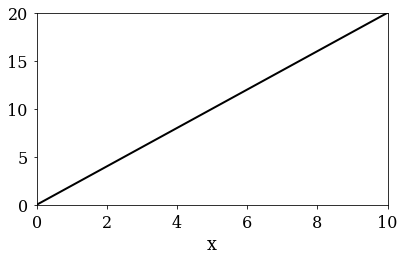

In [4]:
# True line for linear regression model.
x = np.arange(0, 10.1, 0.01)
fig, ax = plt.subplots()
ax.plot(x, 2*x, color='k', lw=2)
ax.set_xlim([0, 10])
ax.set_ylim([0, 20])
ax.set_xlabel('x')
fig.tight_layout()
plt.show()

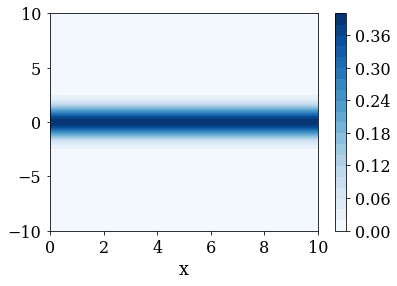

In [5]:
# Noise distribution for linear regression model - assumed Gaussian.

fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
Z = stats.norm.pdf(Y, loc=0)
im = ax.contourf(X, Y, Z, 20, cmap='Blues')
fig.colorbar(im, ax=ax);
ax.set_xlabel('x')
plt.show()

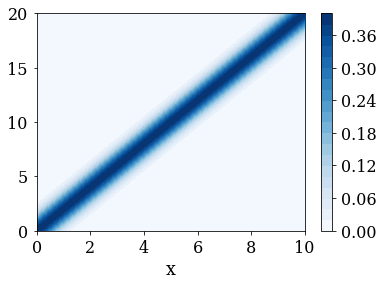

In [6]:
# Response variable generating distribution from model.

fig, ax = plt.subplots()
x = np.linspace(0, 10, 100)
y = np.linspace(0, 20, 200)
X, Y = np.meshgrid(x, y)
Z = stats.norm.pdf(Y, loc=2*x)
im = ax.contourf(X, Y, Z, 20, cmap='Blues')
fig.colorbar(im, ax=ax);
ax.set_xlabel('x')
plt.show()

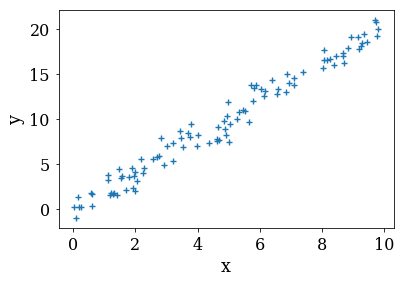

In [7]:
# Sampled data from generating distribution.

x = 10*np.random.random(100)
y = noisy_data(x, coef=[0,2])
fig, ax = plt.subplots()
ax.scatter(x,y, marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

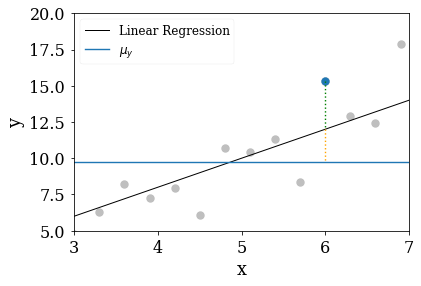

In [27]:
# Illustrate the components of a data point's variance (model-explained and residual)

x = np.arange(0, 10.1, 0.3)
y = noisy_data(x, coef=[0, 2], noise_sigma=2, random_seed=7)

fig, ax = plt.subplots()
ax.plot(x, 2*x, color='k', lw=1, label='Linear Regression')
ax.scatter(x, y, marker='.', s=2**8, color='grey', alpha=0.5)

mu_y = np.mean(y)
plt.axhline(y=mu_y, label='$\mu_y$')

x_i = x[20]
y_i = y[20]
ax.scatter(x_i, y_i, marker='.', s=2**8)
ax.plot([x_i, x_i], [y_i, 2*x_i], color='g', ls=':')
ax.plot([x_i, x_i], [2*x_i, mu_y], color='orange', ls=':')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([3,7])
ax.set_ylim([5, 20])
ax.legend(fontsize=12)
plt.show()

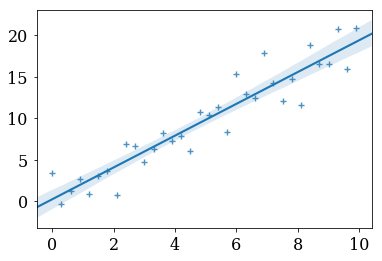

In [28]:
seaborn.regplot(x=x, y=y, marker='+')

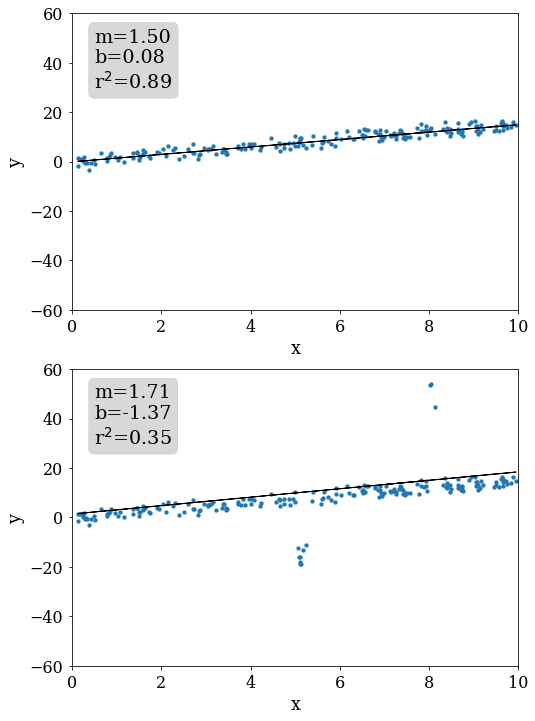

In [36]:
# Example of the influence of outliers on a linear regression.
x = 10*np.random.random(200)
y = noisy_data(x, coef=[0,1.5], noise_sigma=1.5)

fig, ax = plt.subplots(2,1, figsize=(8,12))
props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
for i in range(2):
    if i:
        y[(x>5)&(x<5.25)] *= -2
        y[(x>8)&(x<8.25)] *= 4
    m, b, r_value, p_value, std_err = stats.linregress(x, y)
    ax[i].plot(x, m*x-b, color='k', lw=1)
    dots = ax[i].scatter(x, y, marker='.', s=2**6)
    textstr = 'm={:.2f}\nb={:.2f}\nr$^2$={:.2f}'.format(m, b, r_value**2)
    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes,
               verticalalignment='top', bbox=props)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xlim([0,10])
    ax[i].set_ylim([-60,60])
plt.show()

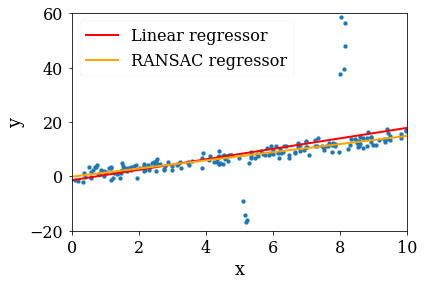

In [39]:
# Comparing simple linear regression with the RANSAC algorithm.
from sklearn import linear_model

x = 10*np.random.random(200)
y = noisy_data(x, coef=[0,1.5], noise_sigma=1.5, random_seed=7)
y[(x>5)&(x<5.25)] *= -2
y[(x>8)&(x<8.25)] *= 4

# Fit linear model using all data
lr = linear_model.LinearRegression()
lr.fit(x.reshape(-1,1), y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x.reshape(-1,1), y)

X_fine = np.arange(X.min(), X.max()+10)[:, np.newaxis]
y_linear = lr.predict(X_fine)
y_ransac = ransac.predict(X_fine)
fig, ax = plt.subplots()
dots = ax.scatter(x,y, marker='.', s=2**6)
ax.plot(X_fine, y_linear, linewidth=2, color='red',
        label='Linear regressor')
ax.plot(X_fine, y_ransac, linewidth=2, color='orange',
        label='RANSAC regressor')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0, 10])
ax.set_ylim([-20, 60])
ax.legend()
plt.show()

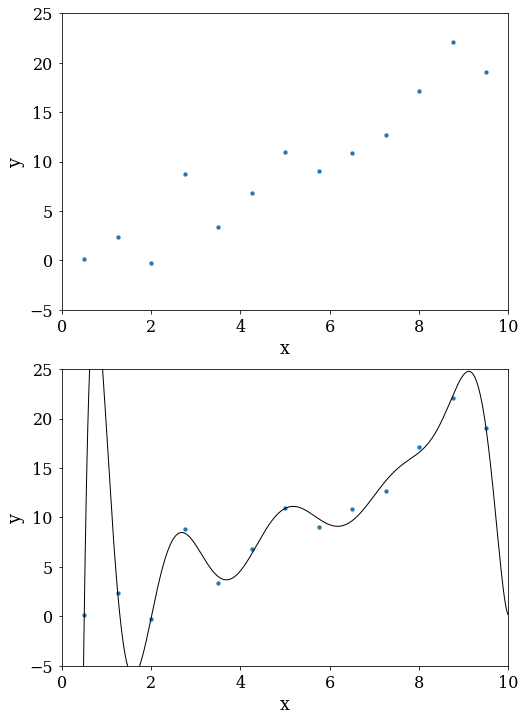

In [47]:
# Overfitting Example

x = np.arange(0.5,10.5,0.75)
y = noisy_data(x, coef=[0, 2], noise_sigma=2.0, random_seed=2)

fig, ax = plt.subplots(2,1, figsize=(8,12))
z = np.polyfit(x, y, 11)
poly = np.poly1d(z)

fine_x = np.arange(0, 11, 0.01)

for i in range(2):
    if i:
        ax[i].plot(fine_x, poly(fine_x), color='k', lw=1)
    ax[i].scatter(x, y, marker='.', s=2**6)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xlim([0,10])
    ax[i].set_ylim([-5,25])
plt.show()

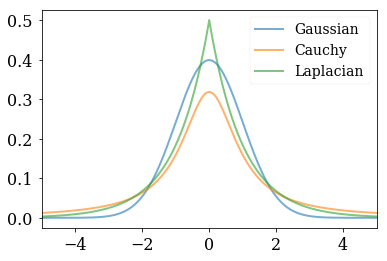

In [48]:
# Changing the error assumption - wider tails.

from scipy.stats import norm, cauchy, laplace

fig, ax = plt.subplots()
dists = [norm, cauchy, laplace]
labels = ['Gaussian', 'Cauchy', 'Laplacian']
for i, dist in enumerate(dists):
    x = np.arange(-10,10,0.001)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.6, label=labels[i])
ax.set_xlim([-5,5])
ax.legend(fontsize=14)
plt.show()

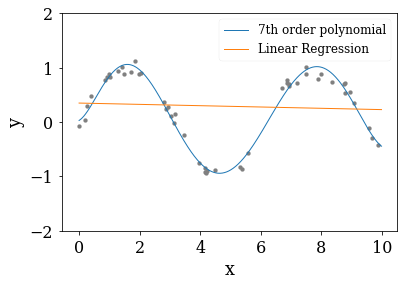

In [49]:
# Polynomial Example

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

fig, ax = plt.subplots()
z = np.polyfit(x, y, 7)
lin = np.poly1d(np.polyfit(x,y,1))
poly = np.poly1d(z)

fine_x = np.arange(0, 10, 0.01)
ax.plot(fine_x, poly(fine_x), lw=1, label='7th order polynomial')
ax.plot(fine_x, lin(fine_x), lw=1, label='Linear Regression')
dots = ax.scatter(x,y, marker='.', s=2**6,color='grey')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(fontsize=12)
ax.set_ylim([-2, 2])
#ax.set_ylim([-5,25])
plt.show()

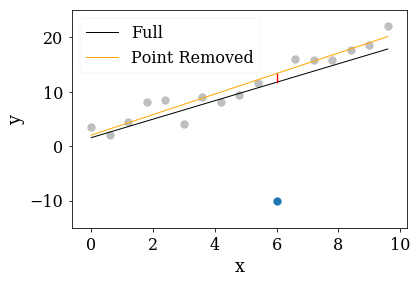

In [53]:
# Cook's distance example.

x = np.arange(0, 10.1, 0.6)
y = noisy_data(x, coef=[0,2], noise_sigma=2)
y[10] = -10

fig, ax = plt.subplots()
m, b, r_value, p_value, std_err = stats.linregress(x, y)
ax.plot(x, m*x+b, color='k', lw=1, label='Full')

mask = np.equal(np.ones(len(x)),1)
mask[10] = False
m1, b1, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
ax.plot(x, m1*x+b1, color='orange', lw=1, label='Point Removed')
ax.scatter(x[mask], y[mask], marker='.', s=2**8, color='grey', alpha=0.5)
ax.scatter(x[~mask], y[~mask], marker='.', s=2**8)

ax.plot([x[~mask], x[~mask]], [m1*x[~mask]+b1, m*x[~mask]+b], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_ylim([-15, 25])
plt.show()